### Systematic Trading Strategies Implementation

In this notebook, our aim is to implement some sytematic trading strategies and to compare them with the buy and hold strategy

In [ ]:
# Libraries importation and notebook initialization
import matplotlib.pyplot as plt                # Python standard plot library
import numpy as np                             # Python basic data science library
import pandas as pd                            # Python standard data science library
import IPython                                 # Used to display native function

In [ ]:
# 1. Load returns data
returns = pd.read_parquet('https://huggingface.co/datasets/guydegnol/bulkhours/resolve/main/FENG25.train_returns.parquet')

# 2. Display the returns data
display(returns.tail(5))

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,...,r591,r592,r593,r594,r595,r596,r597,r598,r599,r600
4995,-0.540055,-2.017492,-0.795873,-0.208297,-0.412664,-0.598462,-0.315121,-0.818800,-0.470790,0.274416,...,-0.154600,0.024704,0.036542,-0.242373,-0.922813,-0.108143,-0.215775,-1.012681,-0.647204,-0.332872
4996,-0.016041,1.280538,0.713886,-0.005654,-0.054005,0.520196,0.177279,-0.173107,0.224169,-0.329151,...,-0.167814,0.007460,0.126254,1.510540,0.283928,-0.021974,1.022605,0.612632,0.815890,-0.000343
4997,0.292207,2.259690,1.362605,0.047566,1.282506,0.405047,-0.446428,1.300824,0.989634,-0.448035,...,1.011031,0.113474,0.406600,-1.065849,1.513520,0.150373,0.186870,4.976197,-0.026070,0.469940
4998,-1.279875,-0.754904,0.277293,-0.154054,-0.579532,-1.210863,-0.265638,-0.098734,-0.752811,0.225179,...,-0.738836,-0.108741,-0.292393,2.086964,-0.219366,-0.147315,-0.340944,-3.309313,0.435462,-0.413616
4999,-1.649810,-0.265443,0.356141,0.615582,0.038551,0.473919,-0.333510,0.715989,-0.178715,1.090434,...,0.740892,-0.007603,-0.662451,-0.101185,-0.305185,-0.159063,-0.349006,-0.730006,0.914715,0.322685


In [ ]:
# Define parameters
risk_target = 0.20  # Annualized risk target (20%)
trading_costs = 0.0005  # Assumed trading cost per turnover
execution_lag = 2  # Execution lag in days
num_assets = returns.shape[1]
initial_weight = 1 / num_assets  # Equal allocation
initial_investment = 1000

In [ ]:
# Creating synthetic prices (assuming starting prices 100)
prices = (1+returns/100).cumprod() * 100

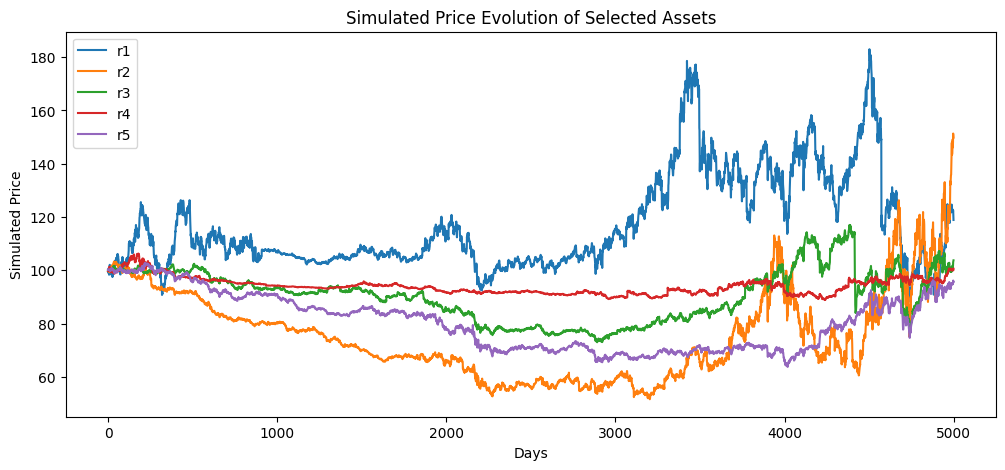

In [ ]:
# Select a few assets for visualization
prices.iloc[:, :5].plot(figsize=(12,5), title="Simulated Price Evolution of Selected Assets")
plt.xlabel("Days")
plt.ylabel("Simulated Price")
plt.show()

### BUY AND HOLD STRATEGY


In [ ]:
### Buy & Hold Portfolio ###
# Compute buy & hold returns (assuming no rebalancing)
portfolio_returns_bh = (returns * initial_weight).sum(axis=1) # Daily returns of equal-weighted portfolio
# Compute turnover (which should be zero for Buy & Hold)
turnover_bh = pd.Series(0, index=returns.index)  # No trading activity
# Compute net portfolio returns (no transaction costs since no rebalancing)
net_portfolio_returns_bh = portfolio_returns_bh  # No trading costs in Buy & Hold

# Compute portfolio statistics
net_portfolio_mean_returns_bh = portfolio_returns_bh.mean()
net_portfolio_vol_returns_bh = portfolio_returns_bh.std()
sharpe_ratio_bh = net_portfolio_mean_returns_bh / net_portfolio_vol_returns_bh * np.sqrt(252)

# Cumulative returns and portfolio value
cum_returns_bh = (1 + net_portfolio_returns_bh / 100).cumprod()
portfolio_value_bh = initial_investment * cum_returns_bh

# Print statistics
print(f"Net portfolio returns (Buy & Hold): {net_portfolio_mean_returns_bh:.4f}")
print(f"Net portfolio vol (Buy & Hold): {net_portfolio_vol_returns_bh:.4f}")
print(f"Sharpe Ratio (Buy & Hold): {sharpe_ratio_bh:.4f}")

Net portfolio returns (Buy & Hold): 0.0045
Net portfolio vol (Buy & Hold): 0.5048
Sharpe Ratio (Buy & Hold): 0.1420


### MOMENTUM + MEAN REVERSION STRATEGIES

In [ ]:
# Compute moving averages
short_ma = prices.rolling(50).mean()
long_ma = prices.rolling(200).mean()

# Compute mean reversion signal using Z-score
rolling_window = 20  # Lookback period
mean_returns = returns.rolling(rolling_window).mean()
std_returns = returns.rolling(rolling_window).std() + 1e-8  # Avoid division by zero
z_score = (returns - mean_returns) / std_returns  # Compute Z-score

# Convert Z-score into trading signals
z_bound = 2  # Boundary for the signal,
mean_reversion_signal = np.where(z_score > z_bound, -1, np.where(z_score < -z_bound, 1, 0))
mean_reversion_signal = pd.DataFrame(mean_reversion_signal, index=returns.index, columns=returns.columns)

# Maximum weight we authorised per asset
max_weight = 0.05

#### MOMENTUM + MEAN REVERSION STRATEGY 1 (based on moving average crossovers + Z-score of short-term returns)

In [ ]:
# Identify crossovers: only update when the sign changes
prev_signal = (short_ma.shift(1) > long_ma.shift(1)).astype(int)  # Previous day signal
current_signal = (short_ma > long_ma).astype(int)  # Current day signal

# - Assign +1 when the short MA crosses above the long MA (bullish crossover)
# - Assign -1 when the short MA crosses below the long MA (bearish crossover)
# - Assign 0 if there is no crossover (i.e., the trend remains unchanged)
momentum_signal_strat1 = np.where(current_signal > prev_signal, 1, np.where(current_signal < prev_signal, -1, 0))
momentum_signal_strat1 = pd.DataFrame(momentum_signal_strat1, index=prices.index, columns=prices.columns) # Convert to DataFrame

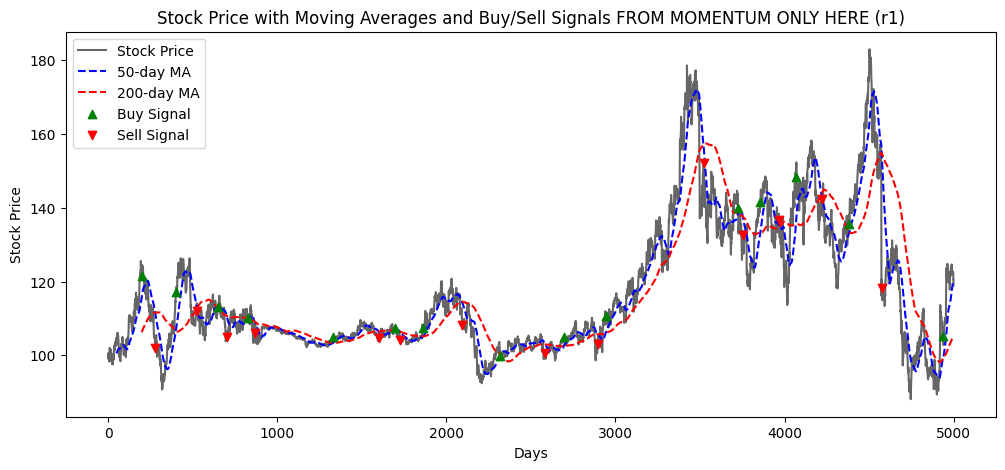

In [ ]:
# Select a single asset (e.g., "r1")
asset = "r1"
prices_asset = prices[asset]
short_ma_asset = short_ma[asset]
long_ma_asset = long_ma[asset]
momentum_signal_asset_strat1 = momentum_signal_strat1[asset]

# Identify buy (+1) and sell (-1) signals
buy_signals = momentum_signal_asset_strat1[momentum_signal_asset_strat1 == 1].index
sell_signals = momentum_signal_asset_strat1[momentum_signal_asset_strat1 == -1].index

# Plot price series with moving averages and buy/sell signals FROM MOMENTUM SIGNAL ONLY HERE
plt.figure(figsize=(12, 5))
plt.plot(prices_asset, label="Stock Price", color="black", alpha=0.6)
plt.plot(short_ma_asset, label="50-day MA", color="blue", linestyle="dashed")
plt.plot(long_ma_asset, label="200-day MA", color="red", linestyle="dashed")

# Plot buy signals (green upward triangles)
plt.scatter(buy_signals, prices_asset.loc[buy_signals], marker="^", color="green", label="Buy Signal", alpha=1, zorder=3)

# Plot sell signals (red downward triangles)
plt.scatter(sell_signals, prices_asset.loc[sell_signals], marker="v", color="red", label="Sell Signal", alpha=1, zorder=3)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title(f"Stock Price with Moving Averages and Buy/Sell Signals FROM MOMENTUM ONLY HERE ({asset})")
plt.legend()
plt.show()

In [ ]:
# Combine signals (Momentum & Mean Reversion)
combined_signal_strat1 = 0.5 * momentum_signal_strat1 + 0.5 * mean_reversion_signal  # Equal weighting
combined_signal_strat1 = combined_signal_strat1.div(combined_signal_strat1.abs().sum(axis=1) + 1e-8, axis=0)  # Normalize
combined_signal_strat1 = combined_signal_strat1.fillna(0)  # Replace NaNs

### Portfolio Management ###
# Initialize portfolio weights with equal allocation
weights_df_strat1 = pd.DataFrame(index=prices.index, columns=prices.columns)
weights_df_strat1.iloc[0] = initial_weight  # Start with equal allocation

# Portfolio rebalancing based on combined signals
adjustment_factor_strat1 = 0.3  # How much weight to shift based on the signal

for t in range(1, len(prices)):
    prev_weights = weights_df_strat1.iloc[t - 1]  # Previous day's weights
    signals = combined_signal_strat1.iloc[t]  # Today's combined signals

    # Adjust weights proportionally to signal strength
    adjusted_weights = prev_weights * (1 + adjustment_factor_strat1 * signals)

    # Ensure non-negative weights
    adjusted_weights = np.clip(adjusted_weights, 0, None)

    # Normalize to ensure the sum of weights = 1
    if adjusted_weights.sum() == 0:
        adjusted_weights = np.full_like(adjusted_weights, initial_weight)  # Reset if all weights are zero
    else:
        adjusted_weights /= adjusted_weights.sum()

    # Apply max weight constraint (5% per asset)
    overweight_mask = adjusted_weights > max_weight  # Identify overweight assets
    excess_weight = adjusted_weights[overweight_mask].sum() - max_weight * overweight_mask.sum()  # Total excess

    if excess_weight > 0:
        adjusted_weights[overweight_mask] = max_weight  # Cap the overweight assets
        remaining_assets = ~overweight_mask  # Assets that are below 5%
        adjusted_weights[remaining_assets] += (excess_weight / remaining_assets.sum())  # Redistribute excess

    # Store new weights
    weights_df_strat1.iloc[t] = adjusted_weights

# Apply execution lag
delayed_weights_df_strat1 = weights_df_strat1.shift(execution_lag)
pd.set_option('future.no_silent_downcasting', True)
delayed_weights_df_strat1 = delayed_weights_df_strat1.bfill().convert_dtypes()

# Compute portfolio returns
portfolio_returns_strat1 = (delayed_weights_df_strat1 * returns.loc[delayed_weights_df_strat1.index]).sum(axis=1)

# Compute turnover and transaction costs
turnover_strat1 = delayed_weights_df_strat1.diff().fillna(0).abs().sum(axis=1)
net_portfolio_returns_strat1 = portfolio_returns_strat1 - trading_costs * turnover_strat1

# Compute portfolio statistics
net_portfolio_mean_returns_strat1 = net_portfolio_returns_strat1.mean()
net_portfolio_vol_returns_strat1 = net_portfolio_returns_strat1.std()
sharpe_ratio_strat1 = net_portfolio_mean_returns_strat1 / net_portfolio_vol_returns_strat1 * np.sqrt(252)

# Cumulative returns and portfolio value
cum_returns_strat1 = (1 + net_portfolio_returns_strat1 / 100).cumprod()
portfolio_value_strat1 = initial_investment * cum_returns_strat1

print(f"Net portfolio returns of strat 1: {net_portfolio_mean_returns_strat1:.4f}")
print(f"Net portfolio vol of strat 1: {net_portfolio_vol_returns_strat1:.4f}")
print(f"Sharpe Ratio of strat 1: {sharpe_ratio_strat1:.4f}")

Net portfolio returns of strat 1: 0.0046
Net portfolio vol of strat 1: 0.4920
Sharpe Ratio of strat 1: 0.1481


In [ ]:
# Calculate the mean weight per asset
weights_mean_strat1 = weights_df_strat1.mean().sort_values(ascending=False)

# Display the top 10 assets with the highest average weight
print(weights_mean_strat1.head(5))

r105    0.002301
r295    0.002288
r126    0.002276
r350    0.002241
r579    0.002221
dtype: object


#### MOMENTUM + MEAN REVERSION STRATEGY 2 (based on moving average spreads and

---

not only crossovers + Z-score of short-term returns)

In [ ]:
# Compute proportional momentum signal (normalized difference between short & long MA
momentum_signal_strat2 = (short_ma - long_ma) / (long_ma + 1e-8)  # Avoid division by zero

In [ ]:
# Combine signals (Momentum & Mean Reversion)
combined_signal_strat2 = 0.5 * momentum_signal_strat2 + 0.5 * mean_reversion_signal  # Equal weighting
combined_signal_strat2 = combined_signal_strat2.div(combined_signal_strat2.abs().sum(axis=1) + 1e-8, axis=0)  # Normalize
combined_signal_strat2 = combined_signal_strat2.fillna(0)  # Replace NaNs

### Portfolio Management ###
# Initialize portfolio weights with equal allocation
weights_df_strat2 = pd.DataFrame(index=prices.index, columns=prices.columns)
weights_df_strat2.iloc[0] = initial_weight  # Start with equal allocation

# Portfolio rebalancing based on combined signals
adjustment_factor_strat2 = 0.3  # How much weight to shift based on the signal

for t in range(1, len(prices)):
    prev_weights = weights_df_strat2.iloc[t - 1]  # Previous day's weights
    signals = combined_signal_strat2.iloc[t]  # Today's combined signals

    # Adjust weights proportionally to signal strength
    adjusted_weights = prev_weights * (1 + adjustment_factor_strat2 * signals)

    # Ensure non-negative weights
    adjusted_weights = np.clip(adjusted_weights, 0, None)

    # Normalize to ensure the sum of weights = 1
    if adjusted_weights.sum() == 0:
        adjusted_weights = np.full_like(adjusted_weights, initial_weight)  # Reset if all weights are zero
    else:
        adjusted_weights /= adjusted_weights.sum()

    # Apply max weight constraint (5% per asset)
    overweight_mask = adjusted_weights > max_weight  # Identify overweight assets
    excess_weight = adjusted_weights[overweight_mask].sum() - max_weight * overweight_mask.sum()  # Total excess

    if excess_weight > 0:
        adjusted_weights[overweight_mask] = max_weight  # Cap the overweight assets
        remaining_assets = ~overweight_mask  # Assets that are below 5%
        adjusted_weights[remaining_assets] += (excess_weight / remaining_assets.sum())  # Redistribute excess

    # Store new weights
    weights_df_strat2.iloc[t] = adjusted_weights

# Apply execution lag
delayed_weights_df_strat2 = weights_df_strat2.shift(execution_lag)
pd.set_option('future.no_silent_downcasting', True)
delayed_weights_df_strat2 = delayed_weights_df_strat2.bfill().convert_dtypes()

# Compute portfolio returns
portfolio_returns_strat2 = (delayed_weights_df_strat2 * returns.loc[delayed_weights_df_strat2.index]).sum(axis=1)

# Compute turnover and transaction costs
turnover_strat2 = delayed_weights_df_strat2.diff().fillna(0).abs().sum(axis=1)
net_portfolio_returns_strat2 = portfolio_returns_strat2 - trading_costs * turnover_strat2

# Compute portfolio statistics
net_portfolio_mean_returns_strat2 = net_portfolio_returns_strat2.mean()
net_portfolio_vol_returns_strat2 = net_portfolio_returns_strat2.std()
sharpe_ratio_strat2 = net_portfolio_mean_returns_strat2 / net_portfolio_vol_returns_strat2 * np.sqrt(252)

# Cumulative returns and portfolio value
cum_returns_strat2 = (1 + net_portfolio_returns_strat2 / 100).cumprod()
portfolio_value_strat2 = initial_investment * cum_returns_strat2


print(f"Net portfolio returns of strat 2: {net_portfolio_mean_returns_strat2:.4f}")
print(f"Net portfolio vol of strat 2: {net_portfolio_vol_returns_strat2:.4f}")
print(f"Sharpe Ratio of strat 2: {sharpe_ratio_strat2:.4f}")

Net portfolio returns of strat 2: 0.0191
Net portfolio vol of strat 2: 0.4862
Sharpe Ratio of strat 2: 0.6243


In [ ]:
# Calculate the mean weight per asset
weights_mean_strat2 = weights_df_strat2.mean().sort_values(ascending=False)

# Display the top 10 assets with the highest average weight
print(weights_mean_strat2.head(5))

r313    0.039714
r284    0.003278
r339    0.003088
r489    0.002672
r155    0.002517
dtype: object


### VOLATILITY SCALLING STRATEGY

In [ ]:
# Initialize dictionary to store results for different volatility windows
risk_target = 0.2
target_vol = risk_target / np.sqrt(252)
vol_window_list = [20, 30, 50, 100]

# Loop over different volatility window sizes
def vol_scalling_strategy(vol_window):
    # Calculate volatility scaling factor
    vol_scaling_factor = target_vol / returns.rolling(window=vol_window).std()
    vol_scaling_factor = vol_scaling_factor.shift(1).fillna(0)  # Shift to avoid lookahead bias

    # Initialize portfolio weights with equal allocation
    weights_df_vol_scaling = pd.DataFrame(index=prices.index, columns=prices.columns)
    weights_df_vol_scaling.iloc[0] = initial_weight  # Start with equal allocation

    # Portfolio rebalancing based on volatility scaling
    for t in range(1, len(prices)):
        prev_weights = weights_df_vol_scaling.iloc[t - 1]  # Previous day's weights
        scaling_factors = vol_scaling_factor.iloc[t]  # Today's scaling factors

        # Adjust weights proportionally to scaling factors
        adjusted_weights = prev_weights * scaling_factors

        # Ensure non-negative weights
        adjusted_weights = np.clip(adjusted_weights, 0, None)

        # Normalize to ensure the sum of weights = 1
        if adjusted_weights.sum() == 0:
            adjusted_weights = np.full_like(adjusted_weights, initial_weight)  # Reset if all weights are zero
        else:
            adjusted_weights /= adjusted_weights.sum()

        # Apply max weight constraint (5% per asset)
        overweight_mask = adjusted_weights > max_weight  # Identify overweight assets
        excess_weight = adjusted_weights[overweight_mask].sum() - max_weight * overweight_mask.sum()  # Total excess

        if excess_weight > 0:
            adjusted_weights[overweight_mask] = max_weight  # Cap the overweight assets
            remaining_assets = ~overweight_mask  # Assets that are below 5%
            adjusted_weights[remaining_assets] += (excess_weight / remaining_assets.sum())  # Redistribute excess

        # Store new weights
        weights_df_vol_scaling.iloc[t] = adjusted_weights

    # Apply execution lag
    delayed_weights_df_vol_scaling = weights_df_vol_scaling.shift(execution_lag)
    delayed_weights_df_vol_scaling = delayed_weights_df_vol_scaling.bfill().convert_dtypes()

    # Compute portfolio returns
    portfolio_returns_vol_scaling = (delayed_weights_df_vol_scaling * returns.loc[delayed_weights_df_vol_scaling.index]).sum(axis=1)

    # Compute turnover and transaction costs
    turnover_vol_scaling = delayed_weights_df_vol_scaling.diff().fillna(0).abs().sum(axis=1)
    net_portfolio_returns_vol_scaling = portfolio_returns_vol_scaling - trading_costs * turnover_vol_scaling

    # Compute portfolio statistics
    net_portfolio_mean_returns_vol_scaling = net_portfolio_returns_vol_scaling.mean()
    net_portfolio_vol_returns_vol_scaling = net_portfolio_returns_vol_scaling.std()
    sharpe_ratio_vol_scaling = net_portfolio_mean_returns_vol_scaling / net_portfolio_vol_returns_vol_scaling * np.sqrt(252)

    # Cumulative returns and portfolio value
    cum_returns_vol_scaling = (1 + net_portfolio_returns_vol_scaling / 100).cumprod()
    portfolio_value_vol_scaling = initial_investment * cum_returns_vol_scaling

    print('----------------------------------------------------------------')
    print(f"Volatility Window: {vol_window}")
    print(f"Net portfolio returns: {net_portfolio_mean_returns_vol_scaling:.4f}")
    print(f"Net portfolio volatility: {net_portfolio_vol_returns_vol_scaling:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio_vol_scaling:.4f}\n")

    return [net_portfolio_mean_returns_vol_scaling, net_portfolio_vol_returns_vol_scaling, sharpe_ratio_vol_scaling, cum_returns_vol_scaling, portfolio_value_vol_scaling, weights_df_vol_scaling]

for vol_window in vol_window_list:
  net_portfolio_vol_returns_strat3, net_portfolio_vol_returns_strat3, sharpe_ratio_strat3, cum_returns_strat3, portfolio_value_strat3, weights_df_strat3 = vol_scalling_strategy(vol_window)


----------------------------------------------------------------
Volatility Window: 20
Net portfolio returns: 0.0019
Net portfolio volatility: 0.2713
Sharpe Ratio: 0.1122

----------------------------------------------------------------
Volatility Window: 30
Net portfolio returns: 0.0021
Net portfolio volatility: 0.2691
Sharpe Ratio: 0.1259

----------------------------------------------------------------
Volatility Window: 50
Net portfolio returns: 0.0011
Net portfolio volatility: 0.2658
Sharpe Ratio: 0.0680

----------------------------------------------------------------
Volatility Window: 100
Net portfolio returns: 0.0014
Net portfolio volatility: 0.2638
Sharpe Ratio: 0.0850



In [ ]:
net_portfolio_mean_returns_strat3, net_portfolio_vol_returns_strat3, sharpe_ratio_strat3, cum_returns_strat3, portfolio_value_strat3, weights_df_strat3 = vol_scalling_strategy(30)


In [ ]:
# Calculate the mean weight per asset
weights_mean_strat3 = weights_df_strat3.mean().sort_values(ascending=False)

# Display the top 10 assets with the highest average weight
print(weights_mean_strat3.head(5))

r77     0.043762
r57     0.041095
r266     0.03655
r505    0.034737
r89      0.03265
dtype: object


### SUMMARY

In [ ]:
# Create a summary table of portfolio performance
performance_summary = pd.DataFrame({
    "Strategy": ["Buy & Hold", "Strategy 1", "Strategy 2", "Strategy 3"],
    "Mean Return": [net_portfolio_mean_returns_bh, net_portfolio_mean_returns_strat1, net_portfolio_mean_returns_strat2, net_portfolio_mean_returns_strat3],
    "Volatility": [net_portfolio_vol_returns_bh, net_portfolio_vol_returns_strat1, net_portfolio_vol_returns_strat2, net_portfolio_vol_returns_strat3],
    "Sharpe Ratio": [sharpe_ratio_bh, sharpe_ratio_strat1, sharpe_ratio_strat2, sharpe_ratio_strat3]
})

# Sort the summary table by Sharpe Ratio in descending order
performance_summary = performance_summary.sort_values(by="Sharpe Ratio", ascending=False)

# Display the sorted table
print(performance_summary.to_string(index=False))

  Strategy  Mean Return  Volatility  Sharpe Ratio
Strategy 2     0.019123    0.486249      0.624301
Strategy 1     0.004589    0.492006      0.148056
Buy & Hold     0.004515    0.504833      0.141969
Strategy 3     0.002135    0.269079      0.125946


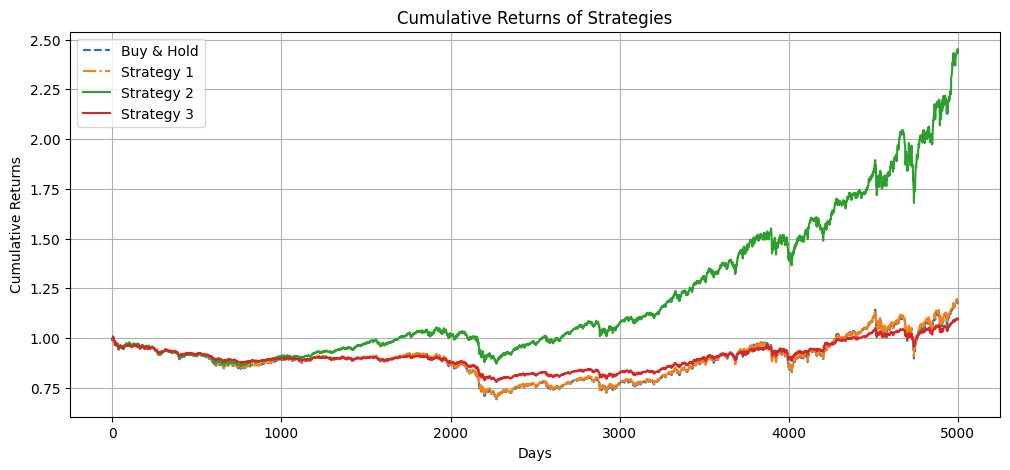

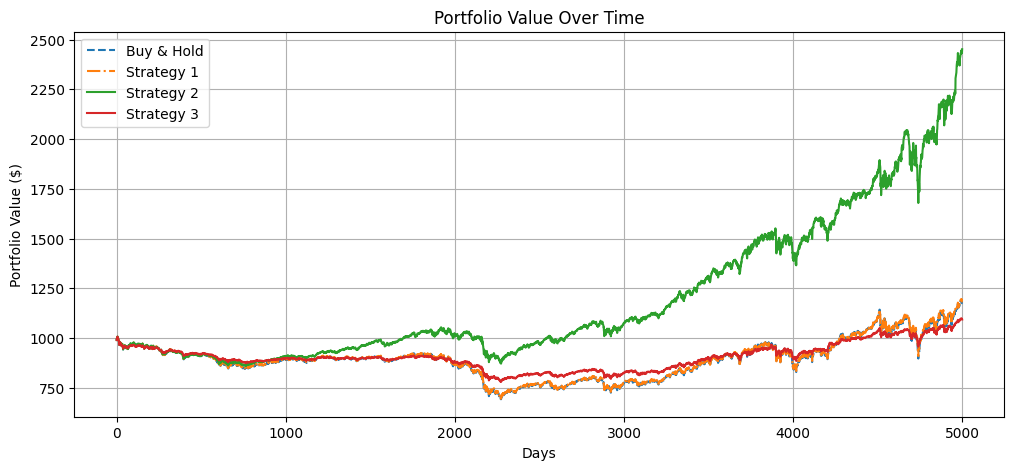

In [ ]:
# Plot cumulative returns
plt.figure(figsize=(12, 5))
plt.plot(cum_returns_bh, label="Buy & Hold", linestyle="--")
plt.plot(cum_returns_strat1, label="Strategy 1", linestyle="-.")
plt.plot(cum_returns_strat2, label="Strategy 2", linestyle="-")
plt.plot(cum_returns_strat3, label="Strategy 3", linestyle="-")
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Strategies")
plt.legend()
plt.grid(True)
plt.show()

# Plot portfolio value over time
plt.figure(figsize=(12, 5))
plt.plot(portfolio_value_bh, label="Buy & Hold", linestyle="--")
plt.plot(portfolio_value_strat1, label="Strategy 1", linestyle="-.")
plt.plot(portfolio_value_strat2, label="Strategy 2", linestyle="-")
plt.plot(portfolio_value_strat3, label="Strategy 3", linestyle="-")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.grid(True)
plt.show()